## Experiments on the MNIST dataset

The goal of this notebook is to train  several classifiers on the classical MNIST database. This database is very popular in the machine learning community as a first test for new algorithms. This dataset is quite simple and artificial : having good results on MNIST does not mean that your algorithm is good, but having bad results surely means that you have to improve your algorithm. You can find reference results on the MNIST dataset [here](http://yann.lecun.com/exdb/mnist/).

You can download the images from [here](http://dataiku.teklia.com/Images/MNIST/MNIST_all.tar_gz)


### Libraries 

We will use the following libraries : 
* sklearn (scikit-learn) for machine learning algorithms
* pandas for manipulating data
* PIL for image processing
* seaborn for graphs


In [1]:
from IPython.display import clear_output
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageFilter
from pprint import pprint
import random
import seaborn as sns
from sklearn import metrics, neighbors, linear_model,svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from time import time

%matplotlib inline

### Feature extraction

The first step is to extract features from the images to convert the image into a feature vectors. ALl the images  have the same size, 32x32 pixels. We reduce them to 8x8 pixels and use the 64 pixels values vector as the features. The function `extract_features_subresolution` process a given image and return the feature vector. The list of all the images is read from the file `Data/MNIST_all.csv`. The features are stored in a matrix `X` and the target class in a vector `y`.

After loading the data, we plot the class distribution.


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Feature size (1000, 64)
Target size (1000,)


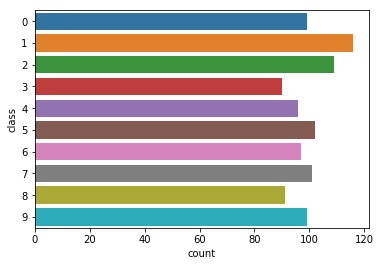

In [2]:
# Progress bar
from tqdm import tqdm_notebook as tqdm

def extract_features_subresolution(img,img_feature_size = (8, 8)):
    """
    Compute the subresolution of an image and return it as a feature vector

    :param img: the original image (can be color or gray)
    :type img: pillow image
    :return: pixel values of the image in subresolution
    :rtype: list of int in [0,255]

    """
    # reduce the image to a given size
    reduced_img = img.resize(
        img_feature_size, Image.BOX).filter(ImageFilter.SHARPEN)
    # return the values of the reduced image as features
    return [i for i in reduced_img.getdata()]

READ_N_SAMPLES = 5000 # use None for reading all samples
# Change it to your MNIST images location
IMAGES_DIR_PATH = '/Users/kermorvant/Work/ESILV/TP/TP_Classification'
FEATURE_SIZE = 8
all_df = pd.read_csv("../data/MNIST_all.csv" ,header=None,names=['filename','class'],nrows=READ_N_SAMPLES)

# plot class distriubtion
sns.countplot(data=all_df,y='class')

# loop on all the image path and extract features
data = []
for i_path in tqdm(all_df['filename']):
    page_image = Image.open(os.path.join(IMAGES_DIR_PATH,i_path))
    data.append(extract_features_subresolution(page_image,(FEATURE_SIZE,FEATURE_SIZE)))

# convert to np.array
X = np.array(data)
y = all_df['class']

print ("Feature size",X.shape)
print ("Target size",y.shape)

Let's have a look to the images after feature sub-resolution and check that our dataset is correct (the lables correspond to the image) : 

You can change FEATURE_SIZE in the previous cell to see the impact of subsampling.

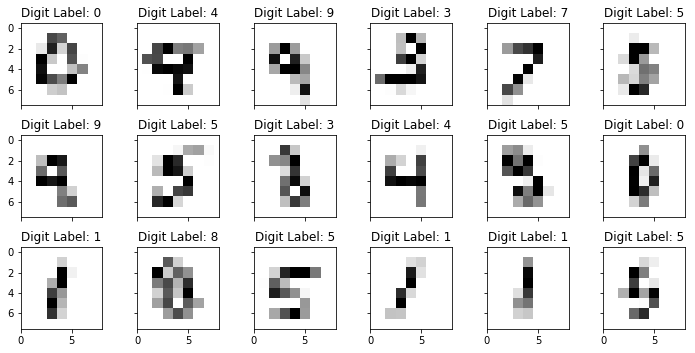

In [3]:
images_to_plot = 18
random_indices = random.sample(range(READ_N_SAMPLES), images_to_plot)

sample_images = X[random_indices, :]
sample_labels = y.loc[random_indices]

fig, axes = plt.subplots(3,6, 
                        figsize=(10,5),
                        sharex=True, sharey=True,
                        subplot_kw=dict(adjustable='box-forced', aspect='equal')) 

for i in range(images_to_plot):
    
    subplot_row = i//6 
    subplot_col = i%6  
    ax = axes[subplot_row, subplot_col]

    # plot image on subplot
    plottable_image = np.reshape(sample_images[i,:], (FEATURE_SIZE,FEATURE_SIZE))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_title('Digit Label: {}'.format(sample_labels.iloc[i]))
    ax.set_xbound([0,FEATURE_SIZE])

plt.tight_layout()
plt.show()

### Train/dev/test split

When training a classifier, the data **must** be separated into different sets : at least one training set and one test set. The split must be random and uniform, which means that the class distribution must be identical in the training and test sets.

> * Use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create `X_train/y_train` and `X_test/y_test`. Use 80% of the data for training and 20% for testing.
> * Train a [k-nearest neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classififier with k=1
> * Test the k-NN with k= 1 on both the training and the test set. Print the score produced by [`clf.score()`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score)

When evaluating a classifier, it is important to report the error rate both on the training and the classification set. These values are needed to understand what is wrong with the classifier and how to improve it.


In [5]:
test_percent = None # YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(None, None, test_size=test_percent, random_state=42)# YOUR CODE HERE

# create a kNN classifier with a given k
k = None # YOUR CODE HERE
clf = neighbors.KNeighborsClassifier(None,n_jobs=-1)# YOUR CODE HERE

# Train the classifier on training set
clf.fit(None,None)# YOUR CODE HERE

# Predict and evaluate on train set
_predicted = clf.predict(None)# YOUR CODE HERE
print ('Train accuracy:',metrics.accuracy_score(None, _predicted))# YOUR CODE HERE
# Predict and evaluate on test set
_predicted = clf.predict(None)# YOUR CODE HERE
print ('Test accuracy:',metrics.accuracy_score(None, _predicted))# YOUR CODE HERE

Train accuracy: 1.0
Test accuracy: 0.815


### Hyperparameter optimization


The main parameter of the kNN algorithm is the number of neighbors (k). The best value for this parameter depends on the classification task and has to be found by trying different values and selecting the one with the best accuracy. However, this search for the best value **must not** be done on the set used to evaluate the classifier (the test set) but on a validation set. 

**Question** : 


>  * Create three sets : train set (60%), validation set (20%) and test set (20%), using twice `train_test_split`
>  * Train a kNN classifier with different values of k and report the train/valid/test accuracy. 
>  * Select the is best value for k according to the accuracy on the dev set. Report the performance performance of the classifier on the test set for this value of k. 

   train   dev  test
1      1  0.76  0.82
3   0.91  0.77  0.82
5   0.87  0.77  0.82
7   0.85  0.77  0.82
9   0.85  0.74  0.81
11  0.85  0.73  0.82


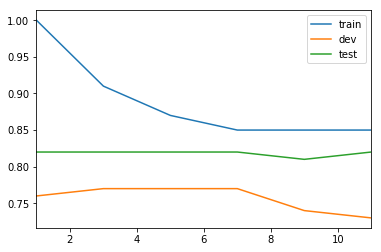

In [6]:
# Create Train/dev/test sets
# YOUR CODE HERE
# Create validation set so that train = 60% , validation = 20% and test =  20%
X_train_dev, X_test, y_train_dev, y_test = train_test_split(None, None, test_size=None)
X_train, X_dev, y_train, y_dev = train_test_split(None, None, test_size=None)


#  list of k values to test
k_values = [None] # YOUR CODE HERE

# store the score in a dataframe
df_scores = pd.DataFrame(columns=['train','dev','test'],index=k_values)

# iterate on différent values of k
for k in k_values:
    print("k={}".format(k))
    
    # create a kNN classifier with a given k
    clf = neighbors.KNeighborsClassifier(None,n_jobs=-1) # YOUR CODE HERE
    
    # Train the classifier on training set
    clf.fit(None,None) # YOUR CODE HERE
    
    # Compute the classification score on the different sets
    for _name,_X,_y in [('train',X_train,y_train),('dev',X_dev,y_dev),('test',X_test,y_test)]:
        df_scores.at[k,_name] = float("{:.2f}".format(clf.score(_X,_y)))
        clear_output(wait=True)
        print(df_scores)
_g = df_scores.plot()


#### Pipelines

Scikit-learn has a special class for dealing with hyperparamter optimization :  [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

We can optimize all the steps (feature extraction, classification) by defining a pipeline. 

To use this, we first convert our feature extraction into a transformer, so that it can be included in the pipeline.

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator


class SubresolFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,col_name='filename', image_dir_path=IMAGES_DIR_PATH,dim=8):
        self.col_name = col_name
        self.image_dir_path = image_dir_path
        self.dim = dim
        
    def transform(self, X, *_):
        data = []
        for i_path in X[self.col_name]:
            page_image = Image.open(os.path.join(self.image_dir_path,i_path))
            data.append(extract_features_subresolution(page_image,(self.dim,self.dim)))
        return np.array(data)
    
    def fit(self, *_):
        return self

The we define the different steps of the pipeline and the different values of the parameters to be tested. 

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('features', SubresolFeatures()),
    ('clf', neighbors.KNeighborsClassifier())
    
])

parameters = {
    'features__dim': (8,),
    'clf__n_neighbors':(1,)
}


Then, the GridSearchCV object will be fitted on the train set with all the possible combinaison of parameter values and evaluated on a validation set with cross validation. The train/dev spit and the cross-validation is done automatically. Progress can be monitored with greater values of the parameter verbose.

**Question** : 


>  *  reproduce the experiments on the parameter k from the previous question using GridSearchCV
>  * add the exploration of different values of the feature dimension. 

In [9]:

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block

    # Define the grid search to find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    # Split the dataframe with the file names in train/test
    df_train_dev, df_test, y_train_dev, y_test = train_test_split(all_df, all_df['class'], test_size=0.2)
    
    print("Performing grid search")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    
    # Run the grid search
    grid_search.fit( None,  None) # YOUR CODE HERE
    all_score = pd.DataFrame(grid_search.cv_results_)
    print (all_score[['params','mean_train_score','mean_test_score']])
    
    # Print all experiments results
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
    # Print best experiment results
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    # predict on test with best parameters
    y_pred = grid_search.predict(None) # YOUR CODE HERE
    print(classification_report(None, None)) # YOUR CODE HERE
    print()


Performing grid search
pipeline: ['features', 'clf']
parameters:
{'clf__n_neighbors': (1,), 'features__dim': (8,)}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


                                        params  mean_train_score  \
0  {'clf__n_neighbors': 1, 'features__dim': 8}               1.0   

   mean_test_score  
0           0.7925  
Grid scores on development set:

0.792 (+/-0.034) for {'clf__n_neighbors': 1, 'features__dim': 8}

Best score: 0.792
Best parameters set:
	clf__n_neighbors: 1
	features__dim: 8
             precision    recall  f1-score   support

          0       1.00      0.90      0.95        20
          1       0.96      0.96      0.96        27
          2       0.92      1.00      0.96        22
          3       0.92      0.80      0.86        15
          4       0.79      0.73      0.76        26
          5       0.67      0.92      0.77        13
          6       0.95      0.90      0.93        21
          7       0.89      0.84      0.86        19
          8       0.61      0.79      0.69        14
          9       0.75      0.65      0.70        23

avg / total       0.86      0.85      0.85       200




## Support Vector Machines


We will now optimize a Support Vector Machine, SVM (Séparateurs à Vaste Marge in French) classifier on the MNIST database. These classifiers usually give very good results if they are well tuned.

All the SVM classifier share a common parameter `C`: it controls how many examples are allowed to be badly classified during the optimization. For small values of C, some training example are allowed to be misclassified if the margin  (the distance between the separating line and the support vector) is large. For large values of C, the algorithm tries to minimize the number of misclassified training example, even if it lead to a small margin. The impact of the value for C is shown on the following figure : 

<p align="center">
  <img src="https://kermorvant.github.io/csexed-ml/images/svm_values_for_C.png" width="400" >
</p>
 

**Question** : 
> * add a linear SVM classifier to the pipline :  [svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with the option `kernel='linear'`
> * add the optimization of `C`  in GridSearchCV 

The RBF kernel (see the [scikit-learn kernels documentation](http://scikit-learn.org/stable/modules/svm.html#svm-kernels) has one more main parameter that must be optimized on the data :  `gamma`.

`gamma` is a parameter controlling the *spread* of the RBF kernel : if `gamma` is small, the kernel takes into account many training samples and the decision boundary is smooth. When `gamma` is large, the kernel is focused on few training examples and the decision boundary is complex. The impact of `gamma` is illustrated on the following Figures : 

- `gamma` = 1
<p align="center">
  <img src="https://kermorvant.github.io/csexed-ml/images/svc_parameters_using_rbf_kernel_17_0.png" width="300" >
</p>

- `gamma` = 100
<p align="center">
  <img src="https://kermorvant.github.io/csexed-ml/images/svc_parameters_using_rbf_kernel_21_0.png" width="300" >
</p>

Moreover, for the RBF kernel, the data must be normalizedn you can use the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale to [zero mean and unit variance](https://en.wikipedia.org/wiki/Feature_scaling#Standardization).  

**Question** : 
> * add the StandardScaler as a pipeline step
> * add the RBF kernel to the GridSearch [svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) 
> * add the optimization of  `gamma` and `C` with values :  `C in [0.5,2,10]` and `gamma in [0.05,0.1,0.5]`. 

You can add a different kernel with its specific parameters this way : 
<pre>
        {
         'features__dim': (8,),
         'clf__kernel': ['rbf'],
         'clf__gamma': [1e-3, ],
         'clf__C': [1,]
        },
</pre>



In [16]:
pipeline = Pipeline([
    ('features', SubresolFeatures()),
    ('scaler',StandardScaler()),
    ('clf', svm.SVC())
   
    
])


parameters = [
        {
        'features__dim': (8,),
        'clf__kernel': ['linear'],
        'clf__C': [1,]
        },
        {
         'features__dim': (8,),
         'clf__kernel': ['rbf'],
         'clf__gamma': [1e-3, ],
         'clf__C': [1,]
        },
]


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2)

    df_train_dev, df_test, y_train_dev, y_test = train_test_split(all_df, all_df['class'], test_size=0.2)
    
    print (df_train_dev.shape,df_test.shape,y_train_dev.shape,y_test.shape)
    print("Performing grid search")

    grid_search.fit( df_train_dev,  y_train_dev)
    
    # Print all experiments results
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
    # Print best experiment results
    print("Best score: %0.3f" % grid_search.best_score_)

    # predict on test with best parameters
    y_pred = grid_search.predict(df_test)
    print(classification_report(y_pred, y_test))
    print()


(800, 2) (200, 2) (800,) (200,)
Performing grid search
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__C=1, clf__kernel=linear, features__dim=8 ...................
[CV] clf__C=1, clf__kernel=linear, features__dim=8 ...................
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8 ....
[CV] clf__C=1, clf__kernel=linear, features__dim=8 ...................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarni

[CV] .... clf__C=1, clf__kernel=linear, features__dim=8, total=   1.0s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8 ....
[CV] .... clf__C=1, clf__kernel=linear, features__dim=8, total=   1.1s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8 ....
[CV] .... clf__C=1, clf__kernel=linear, features__dim=8, total=   1.2s
[CV]  clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8, total=   1.2s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.5s remaining:    1.5s


[CV]  clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8, total=   0.3s
[CV]  clf__C=1, clf__gamma=0.001, clf__kernel=rbf, features__dim=8, total=   0.3s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Grid scores on development set:

0.792 (+/-0.056) for {'clf__C': 1, 'clf__kernel': 'linear', 'features__dim': 8}
0.639 (+/-0.020) for {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'features__dim': 8}

Best score: 0.792
             precision    recall  f1-score   support

          0       0.94      0.94      0.94        18
          1       1.00      0.87      0.93        23
          2       0.94      0.68      0.79        22
          3       0.81      0.81      0.81        26
          4       0.83      0.79      0.81        19
          5       0.56      0.88      0.68        16
          6       0.89      0.85      0.87        20
          7       0.82      0.78      0.80        18
          8       0.53      0.64      0.58        14
          9       0.75      0.75      0.75        24

avg / total       0.82      0.80      0.81       200


